In [1]:
import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.inference                      import elbo as elbo_py
from mrashpen.inference                      import coordinate_descent_step as cd_step
from mrashpen.models                         import mixture_gaussian as mix_gauss

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = obj[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    
def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.elbo_path[-1], obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def linreg_summary_df_noelbo(sigma2, objs, methods):
    data     = [[strue * strue, '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def get_elbos(X, y, b, w, sk, s2):
    elbo1 = cd_step.elbo(X, y, sk, b, w, s2)

    dj     = np.sum(np.square(X), axis = 0)
    r      = y - np.mean(y) - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash  = NormalMeansASHScaled(btilde, np.sqrt(s2), w, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()
    elbo2  = elbo_py.scalemix(X, y, sk, b, w, s2,
                              dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
    return elbo1, elbo2

In [2]:
n = 200
p = 2000
p_causal = 50
pve = 0.95
rho = 0.0
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 100)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [3]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
winit  = mix_gauss.emfit(lasso_b, sk)
print ("Lasso initialization")

'''
mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True, maxiter = 4000)
plr_lbfgs.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)
#plr_lbfgs = lbfgsfit.method_fixseq_simple(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)


'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init, 
               maxiter = 400, qb_maxiter = 50)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = winit, s2init = s2init)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

R[write to console]: Loading required package: Matrix



Lasso initialization
mr.ash.pen terminated at iteration 421.
mr.ash.pen (EM) terminated at iteration 400.
Mr.ASH terminated at iteration 282.
Mr.ASH terminated at iteration 10.


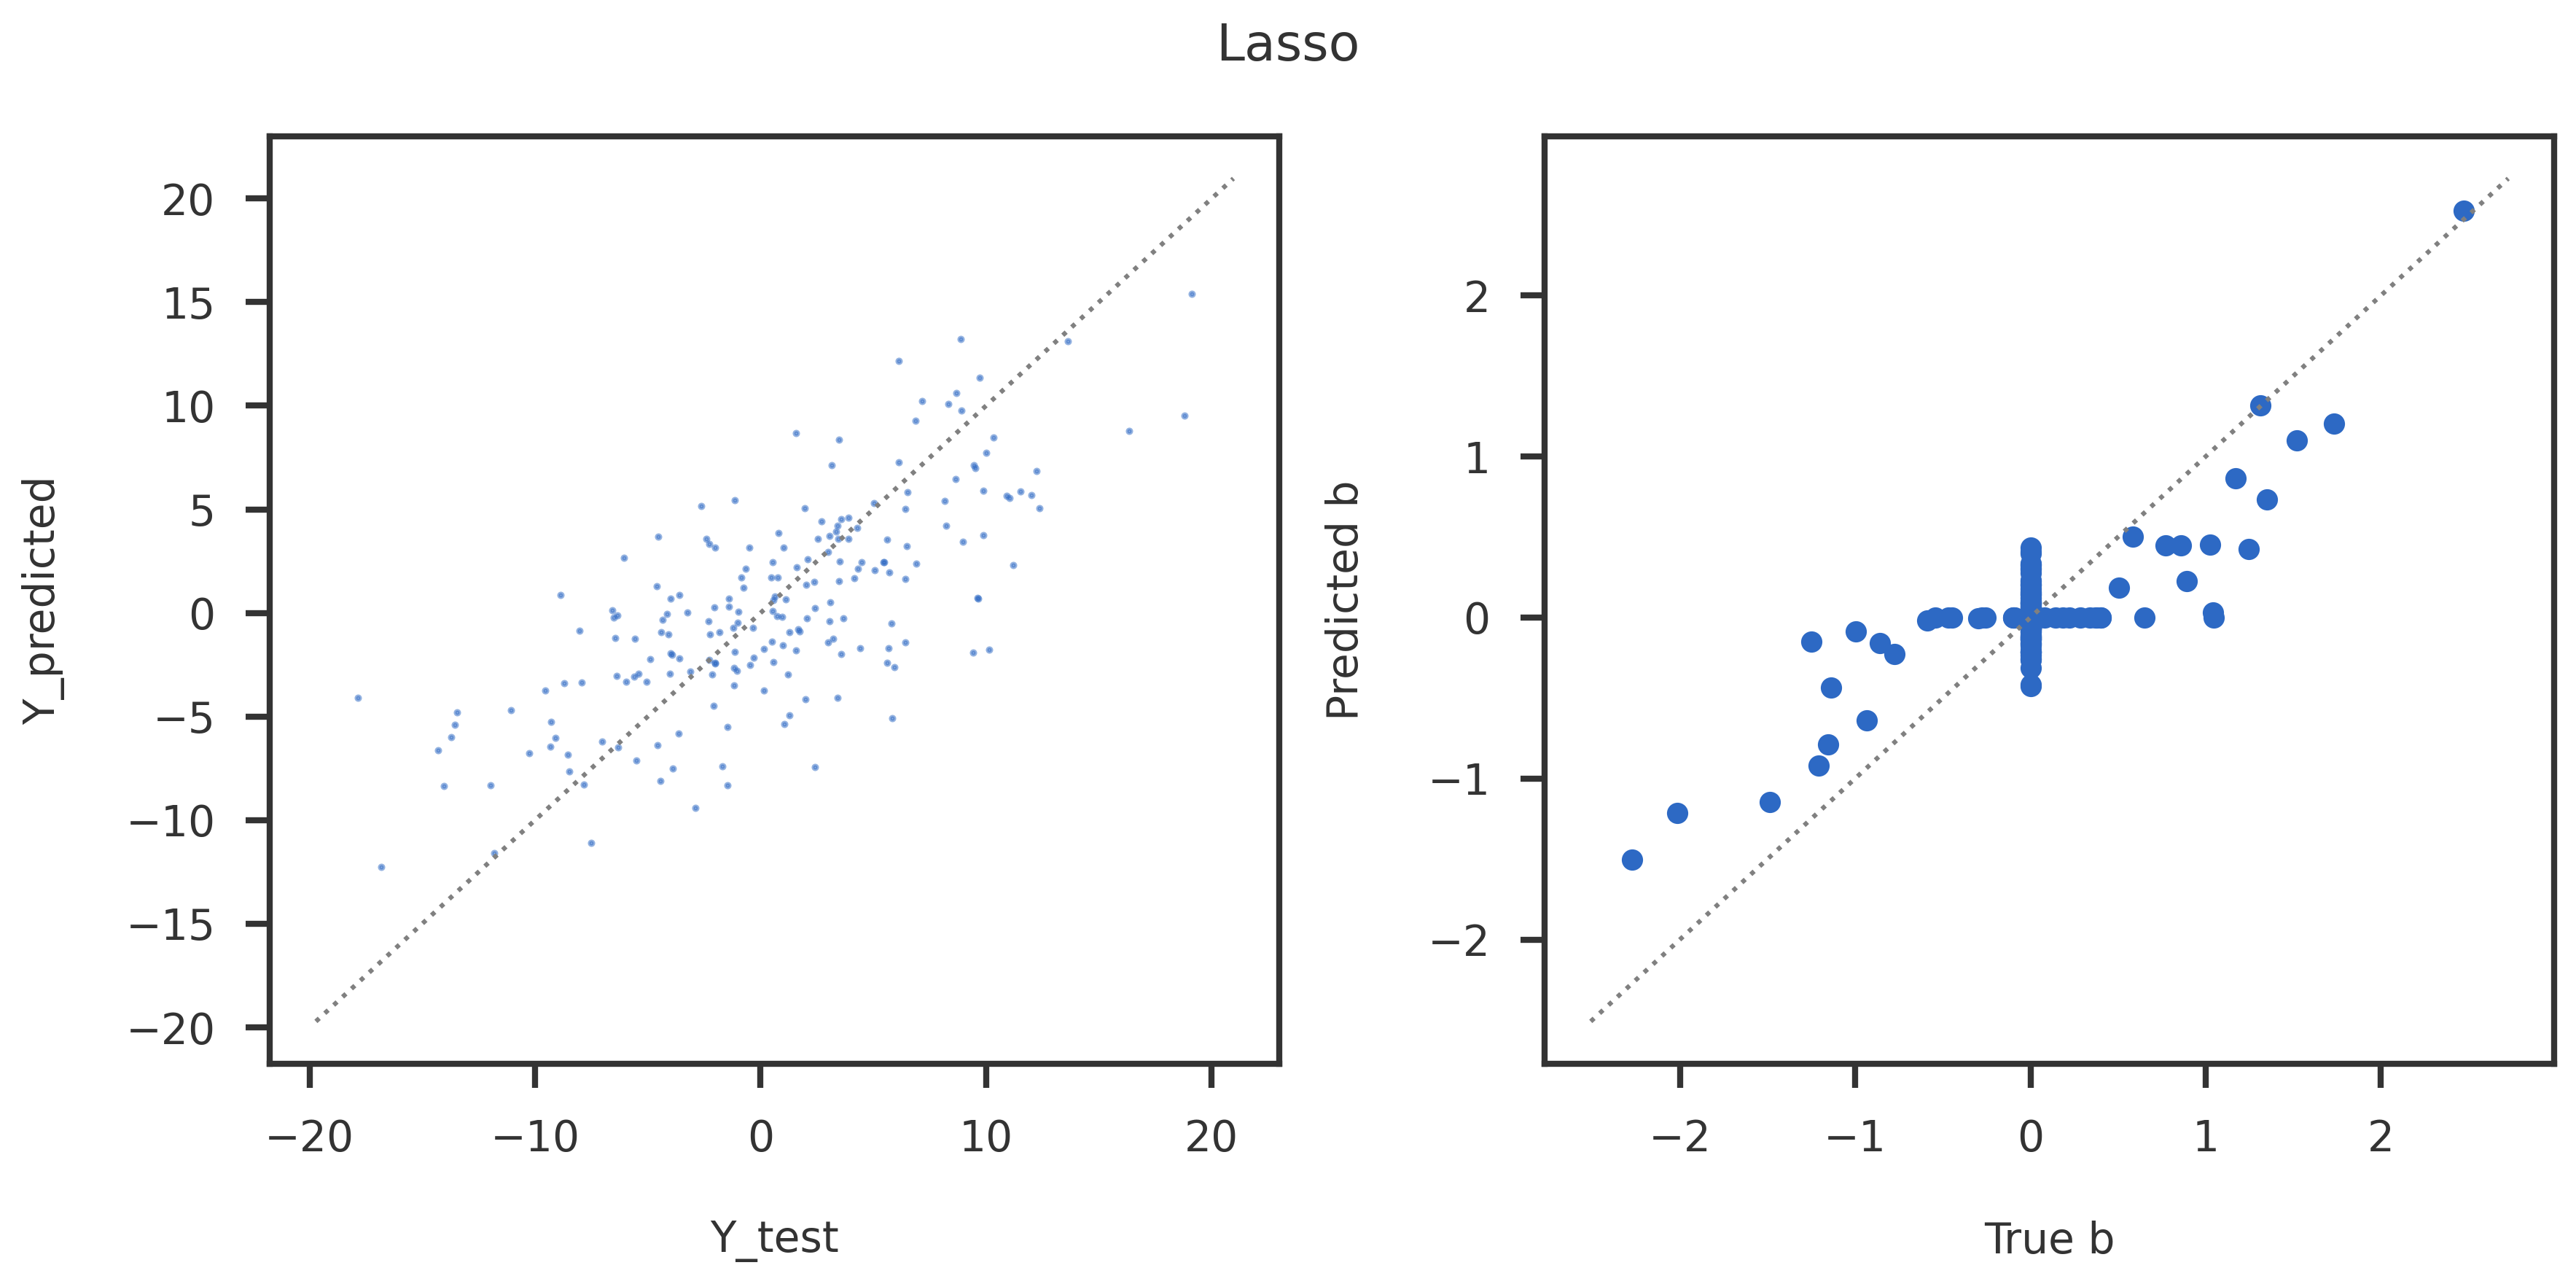

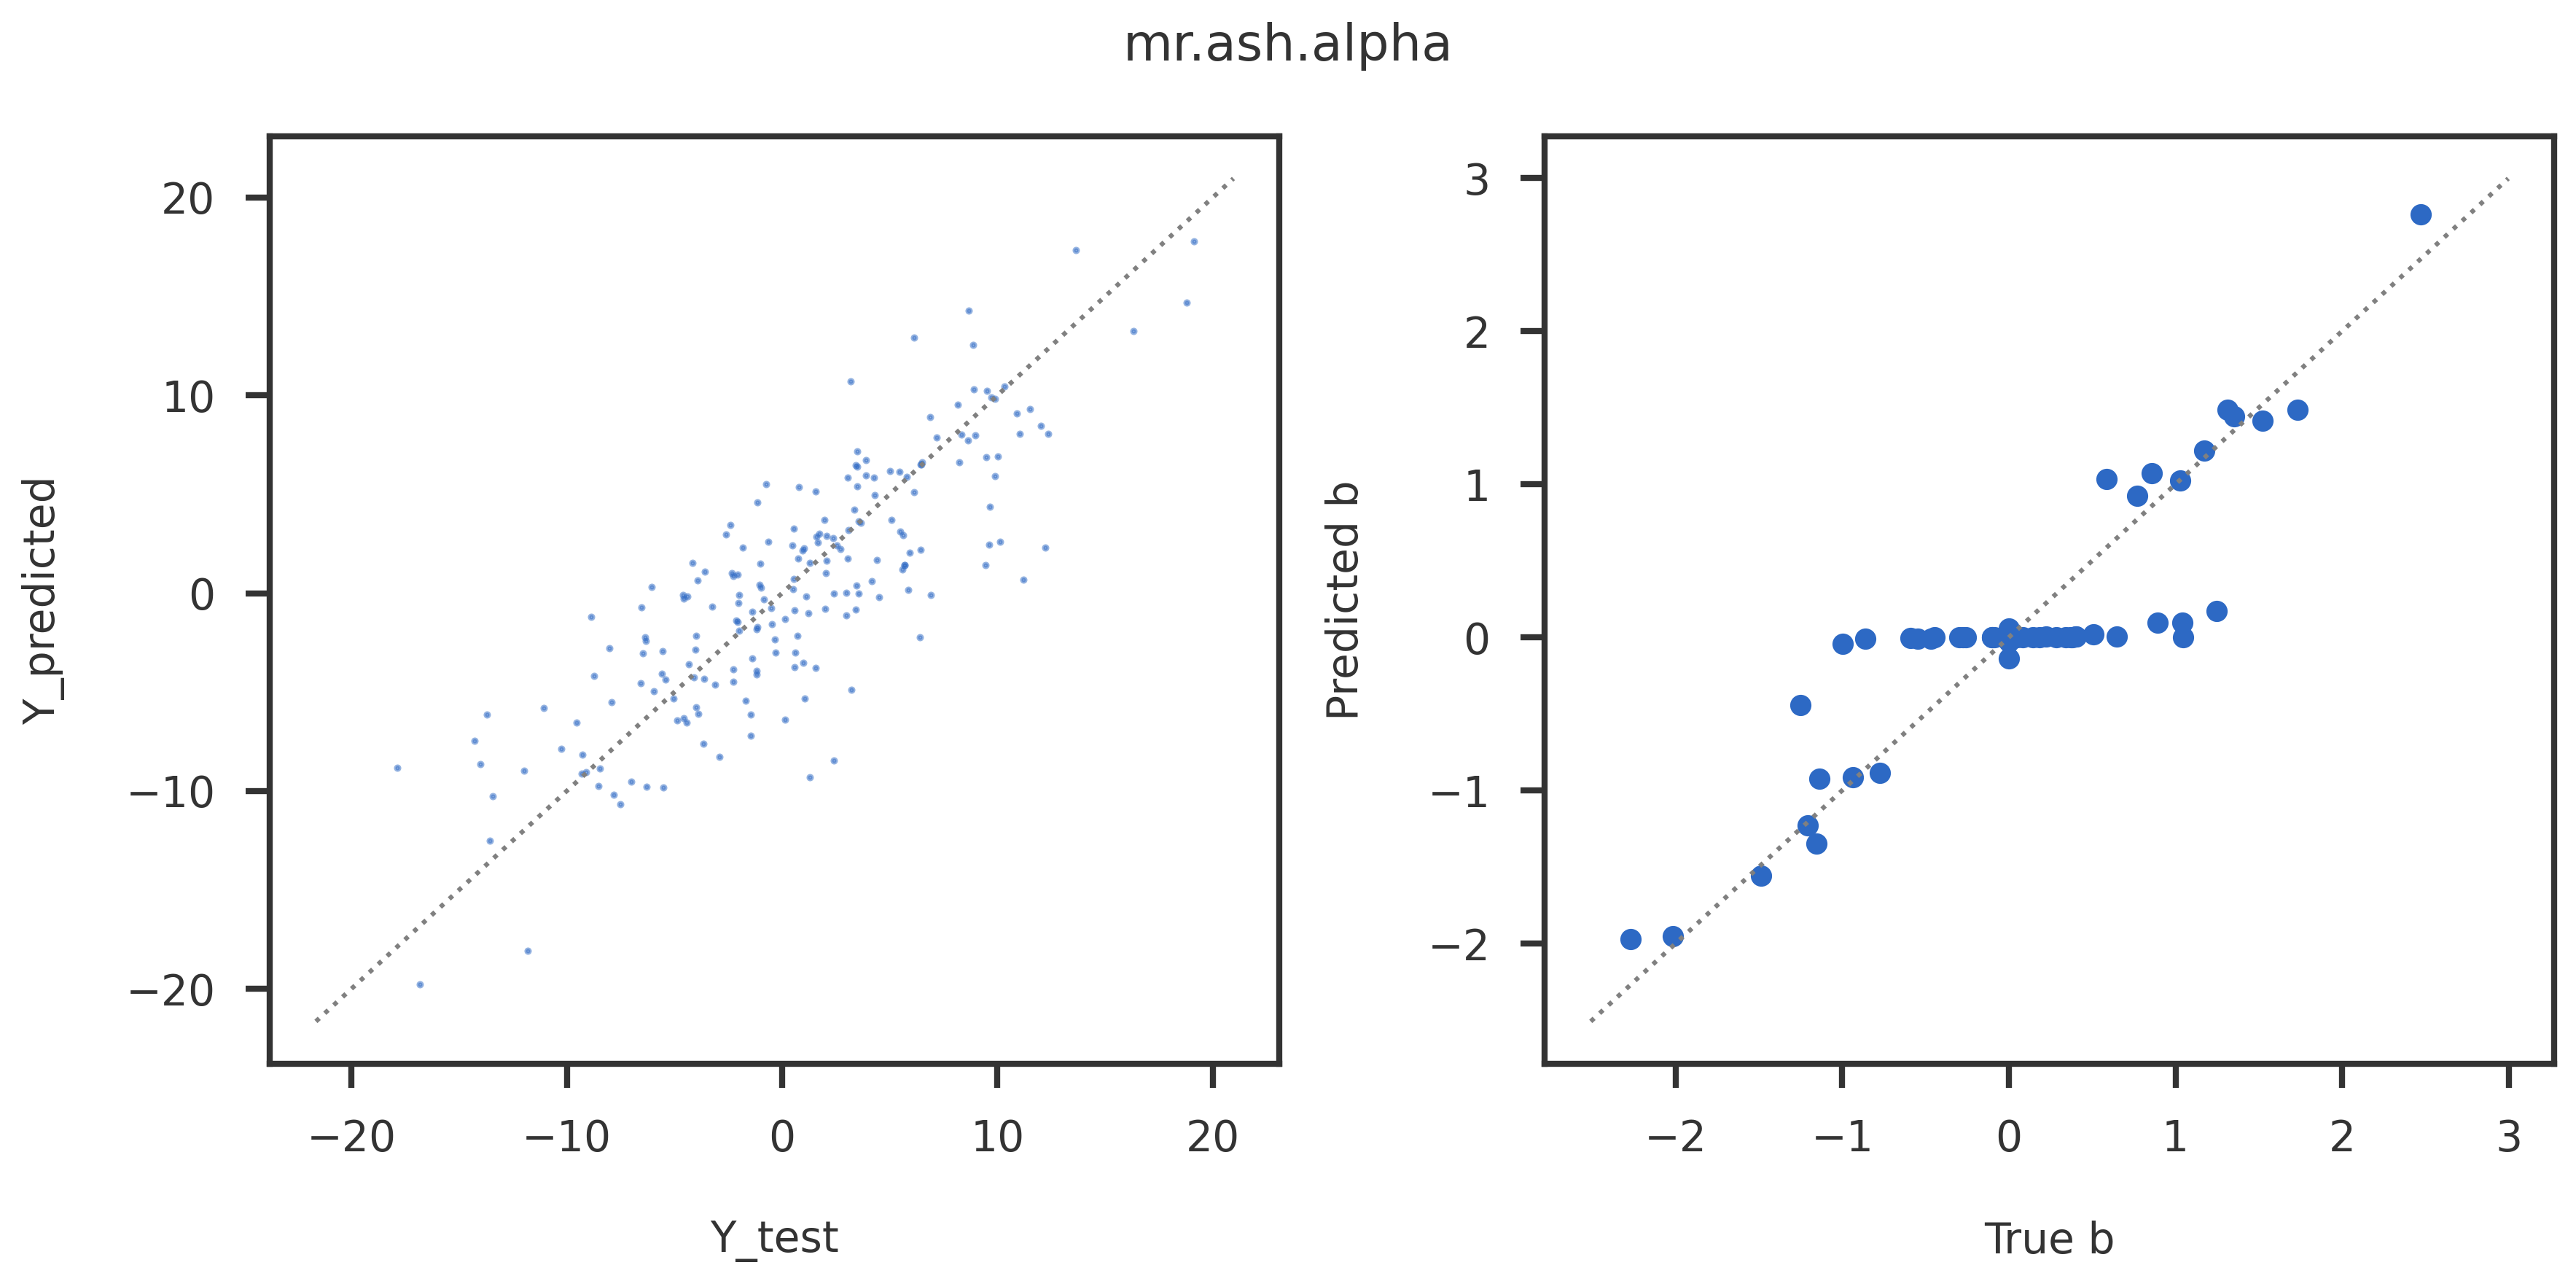

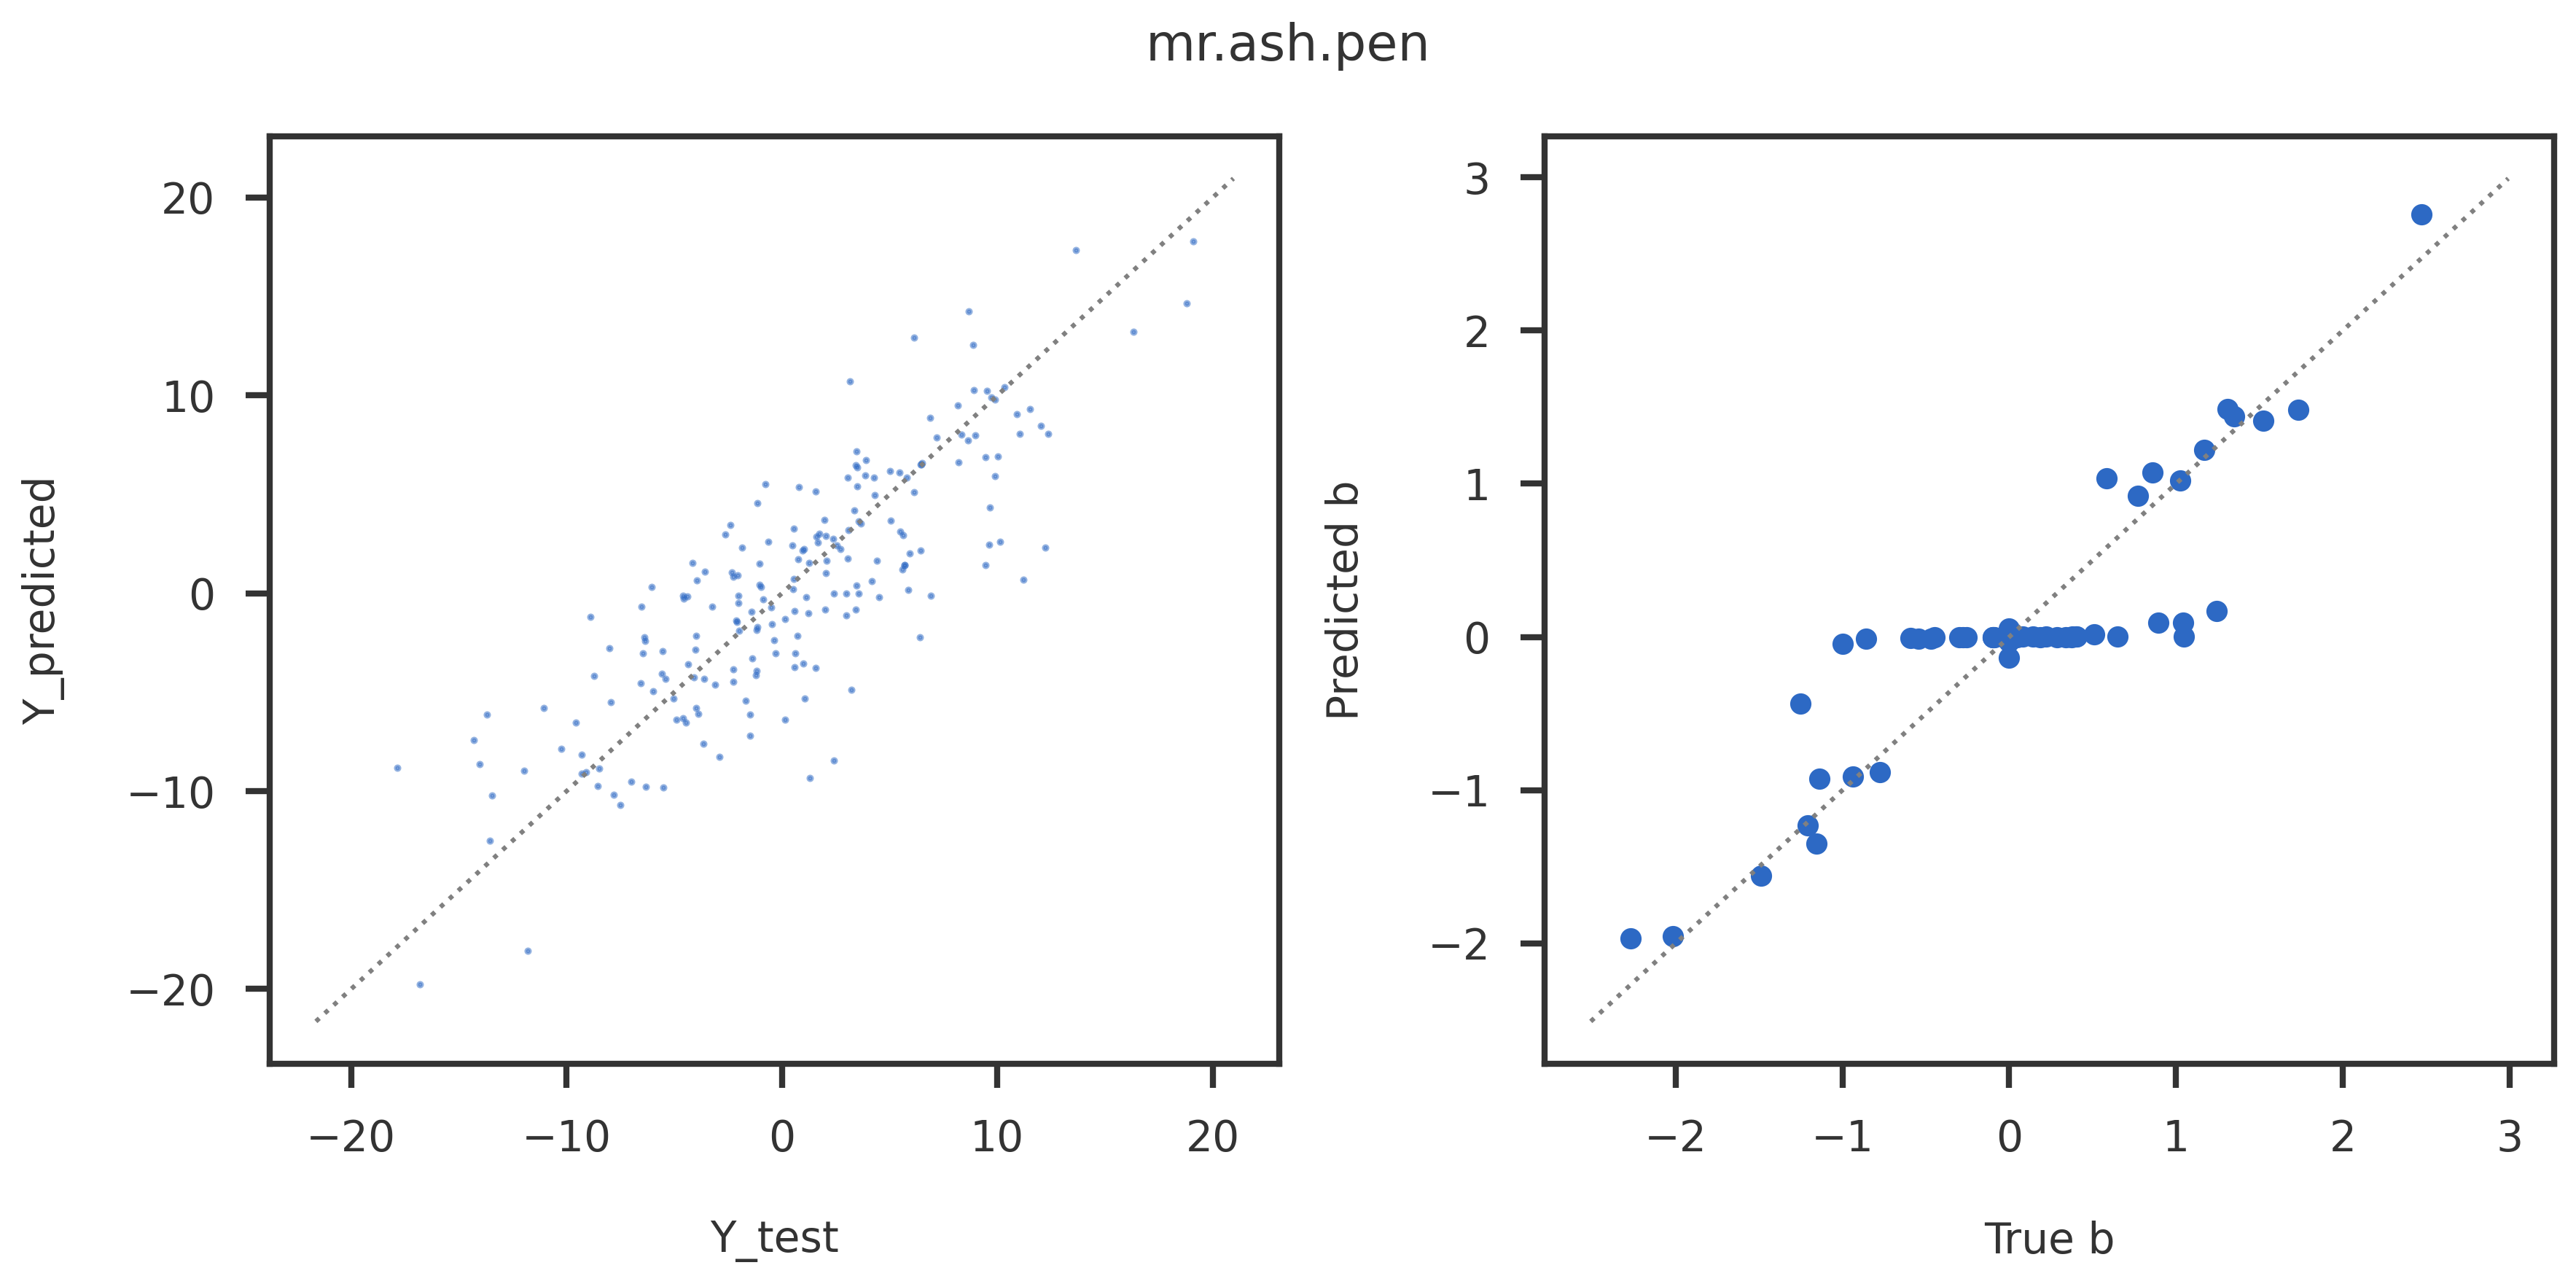

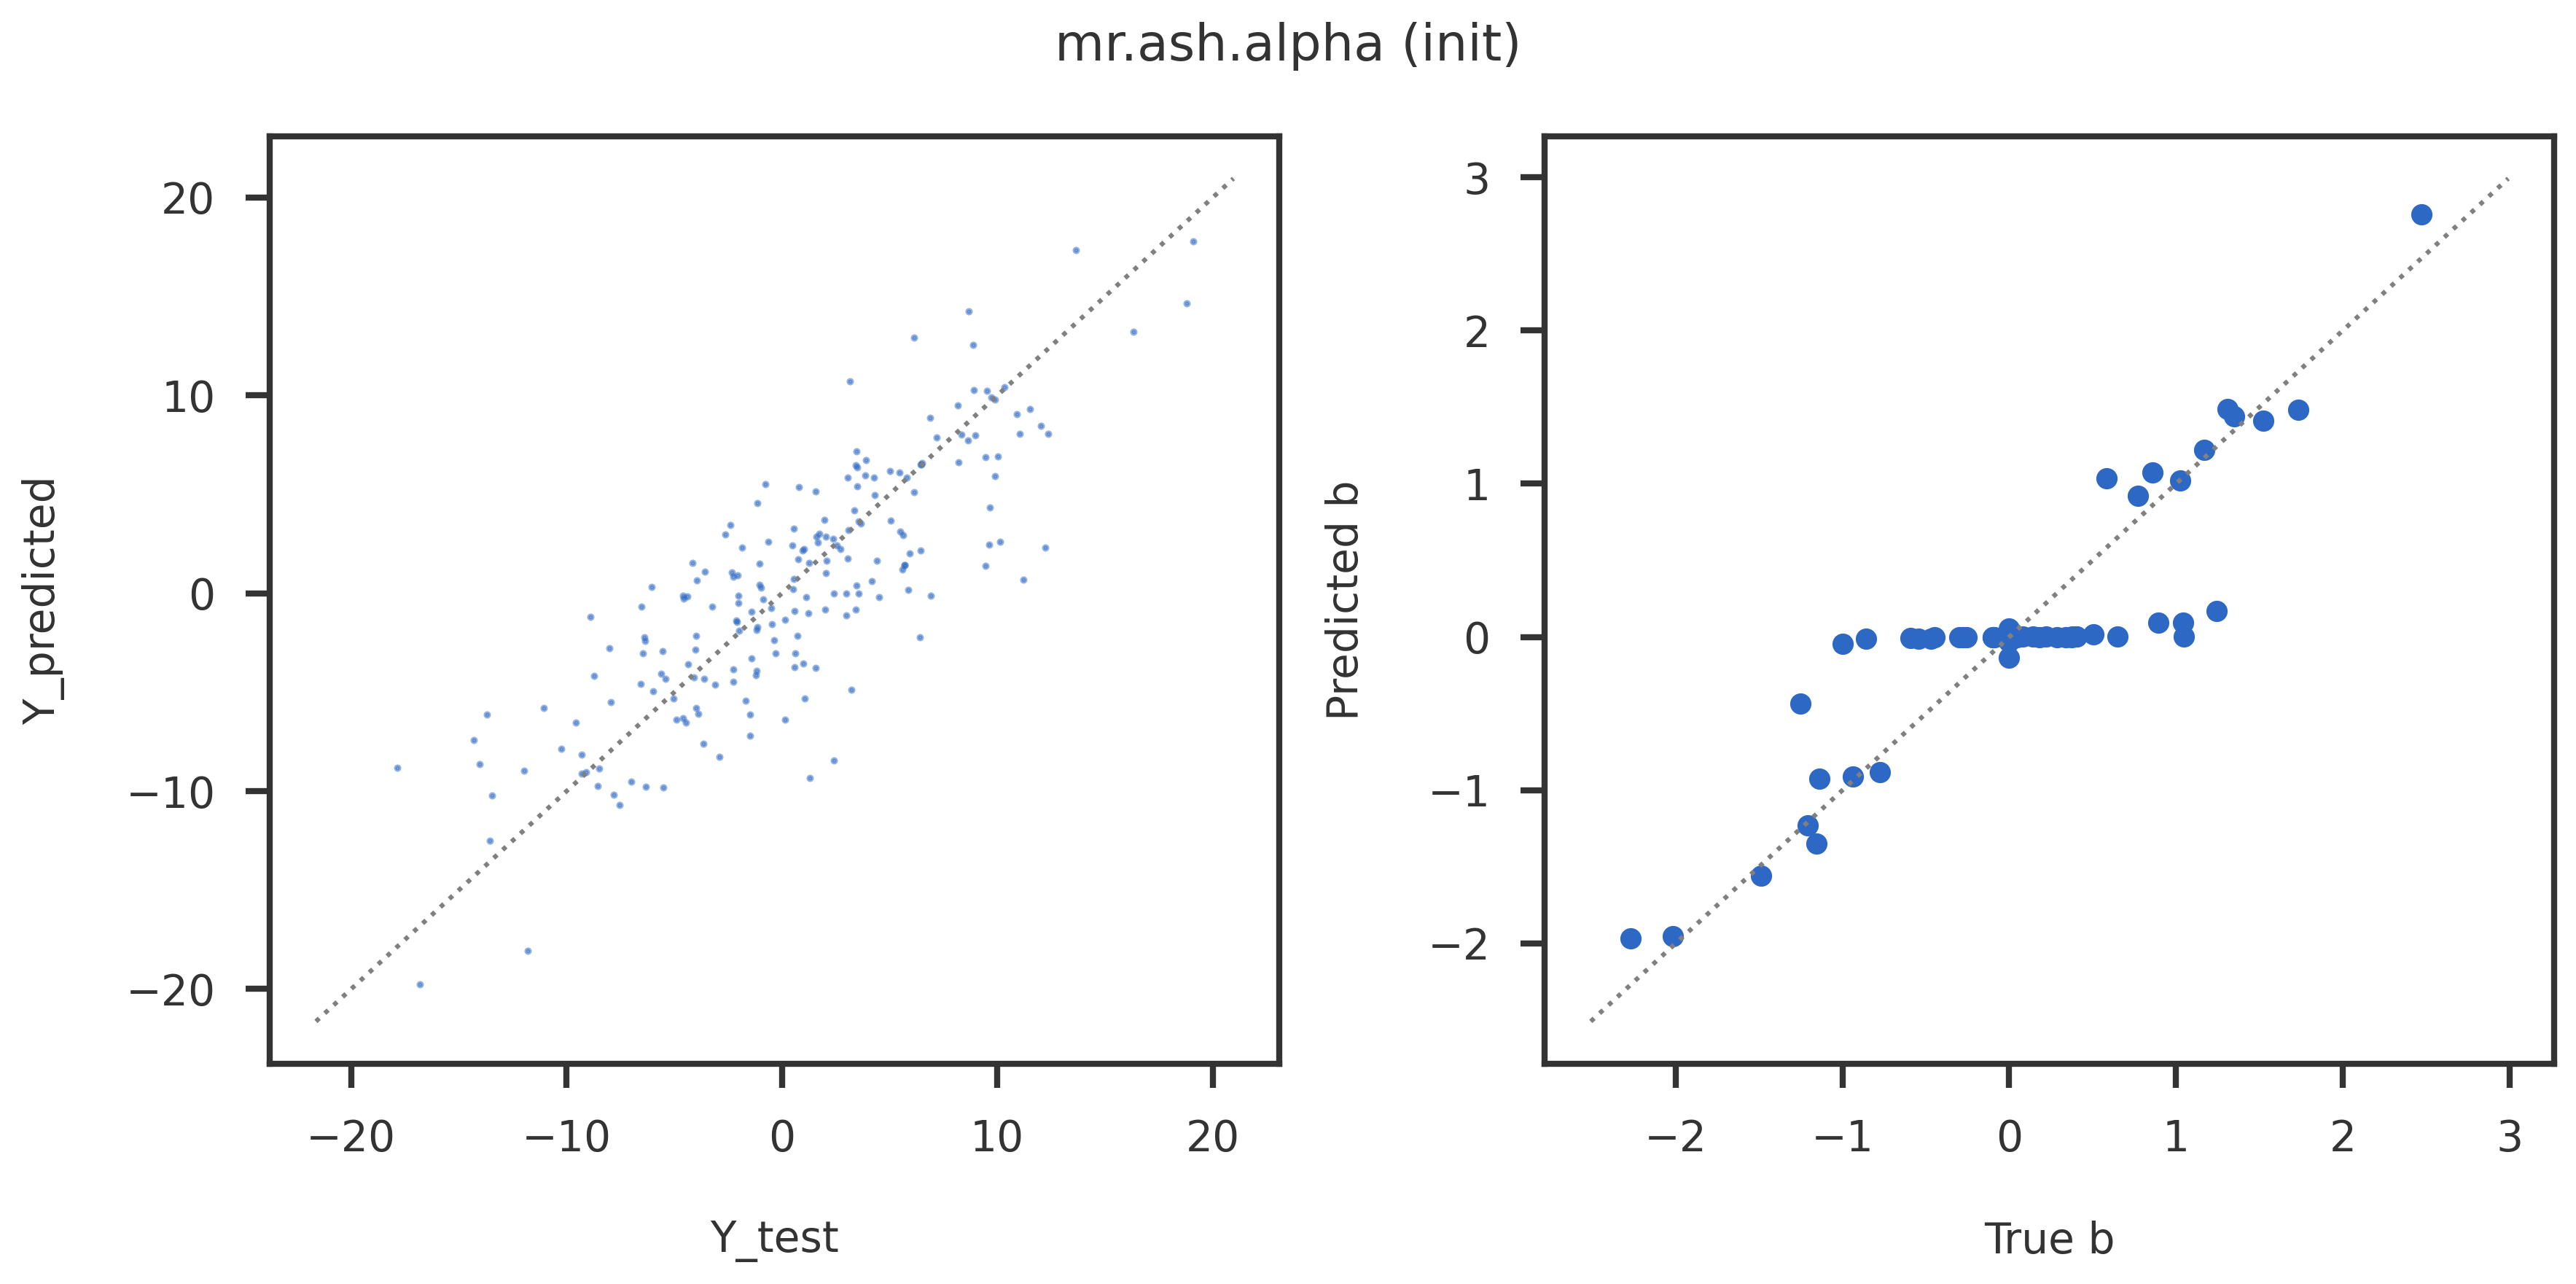

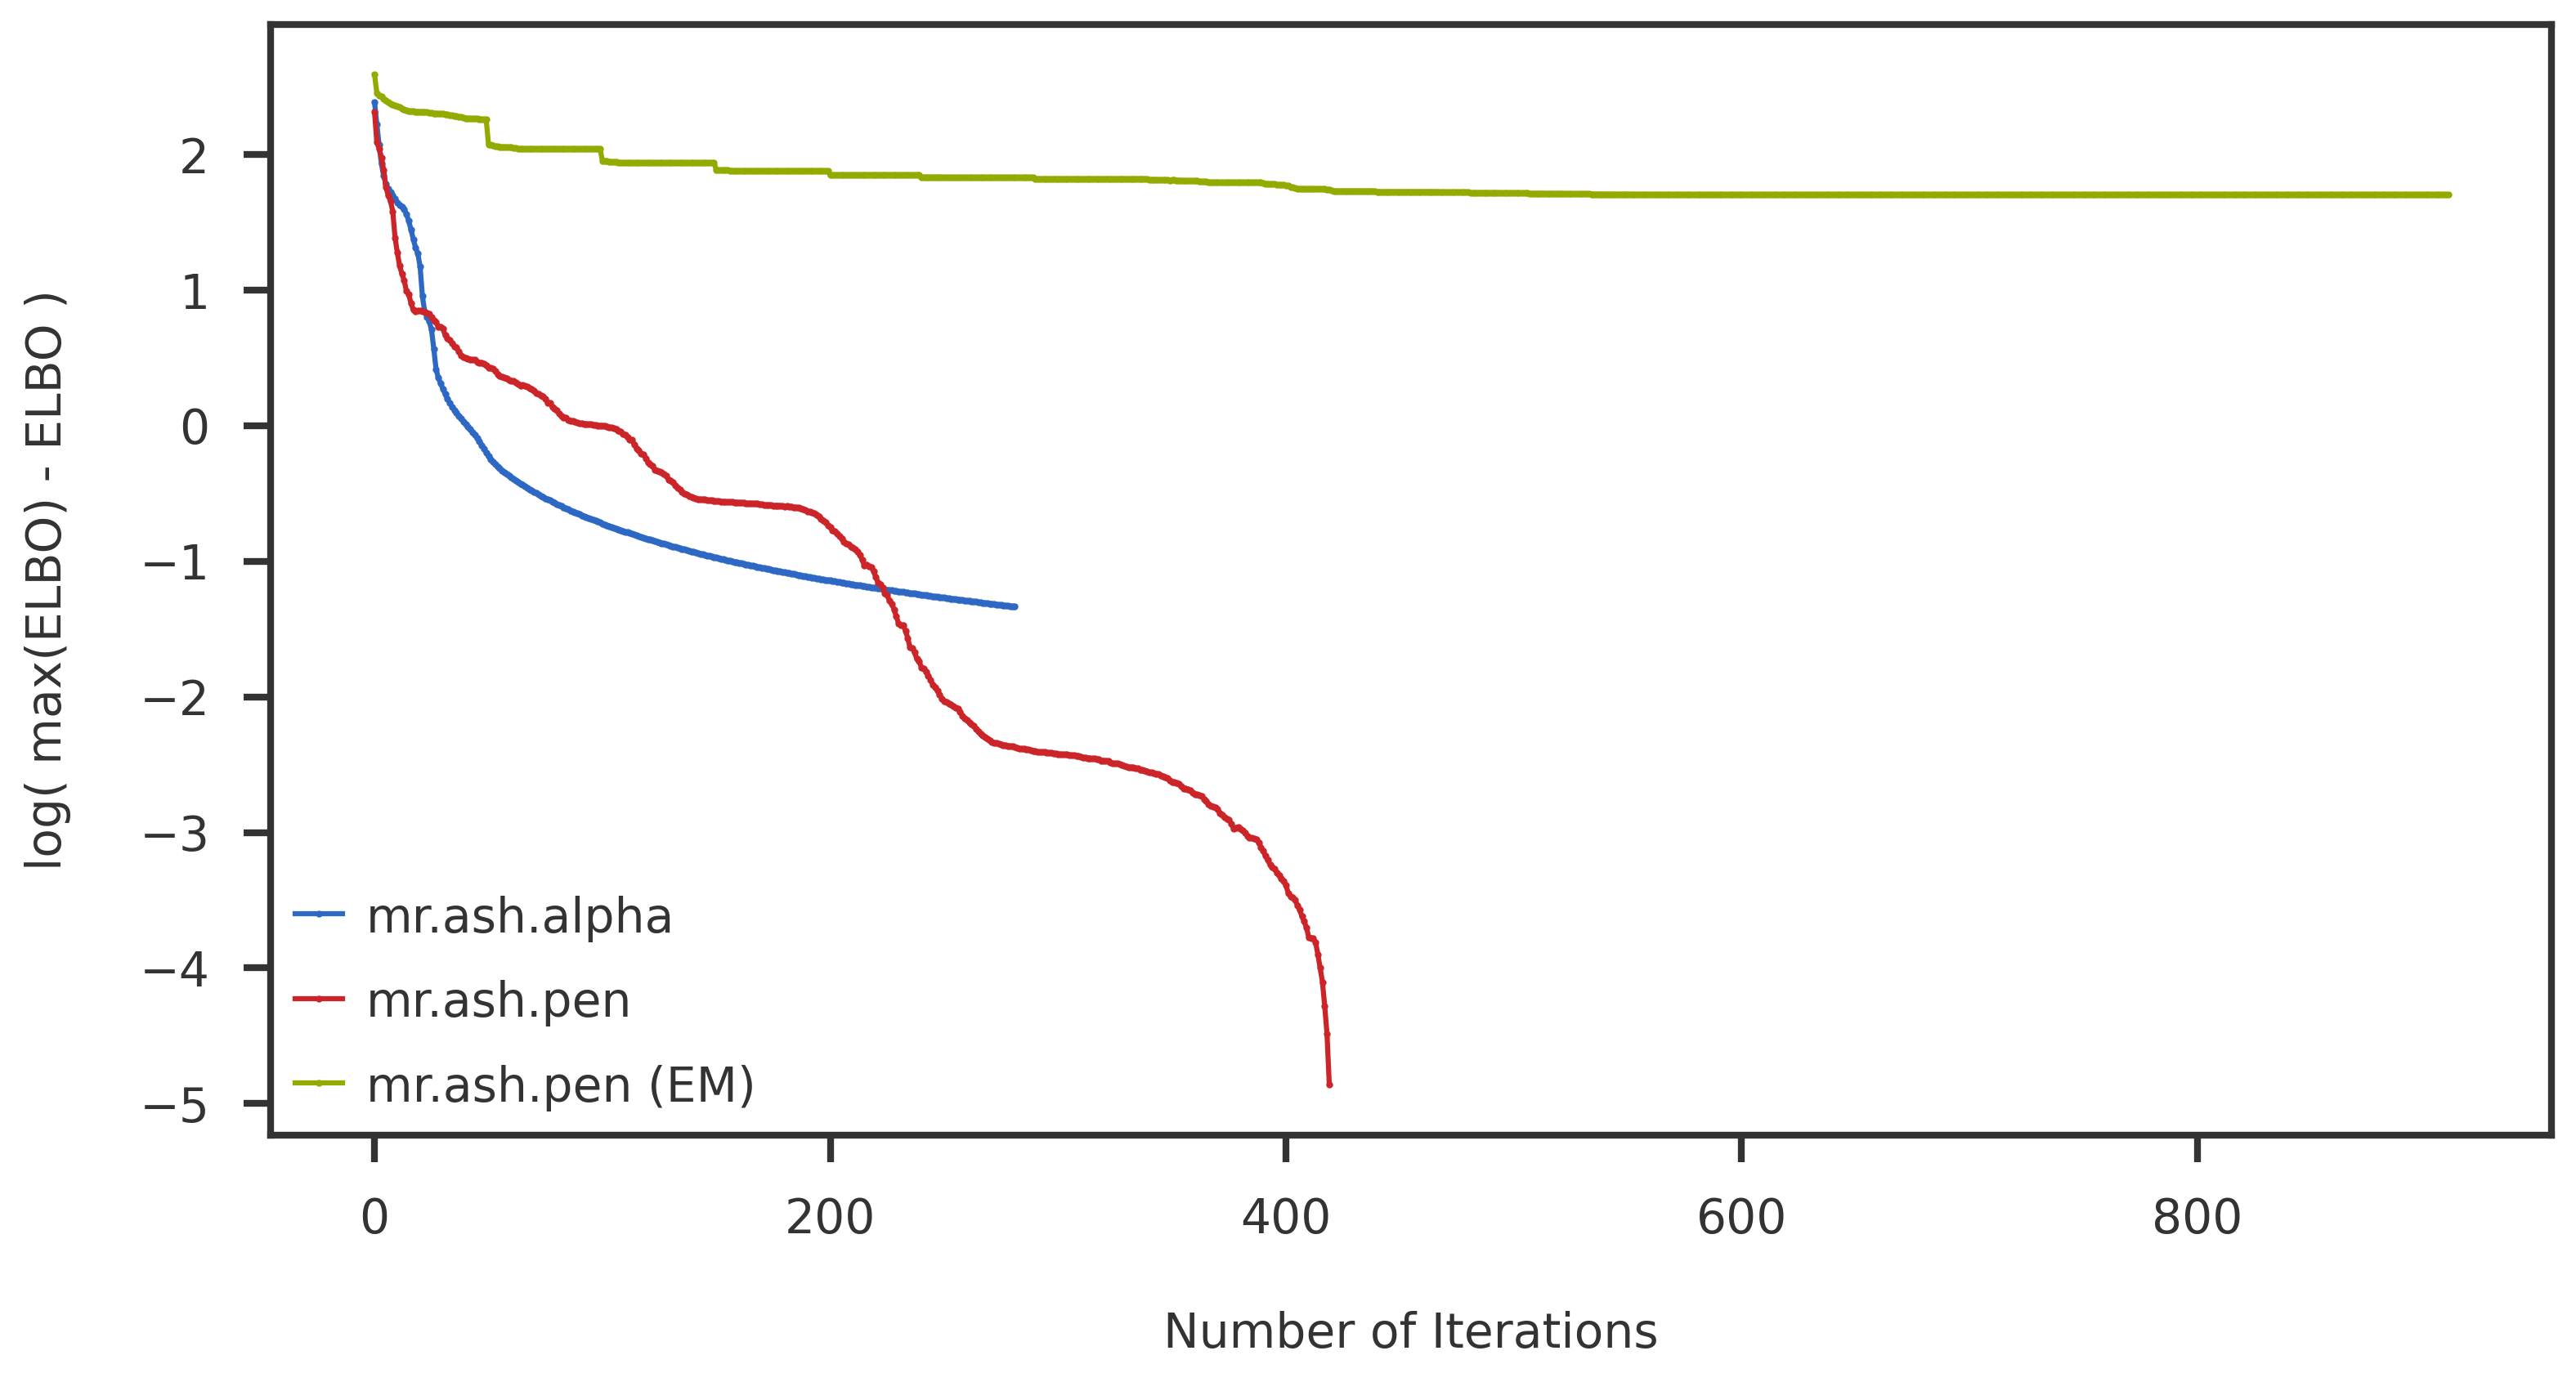

In [8]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue,
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
#plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
#                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
# kinit   = [0, 0]
# objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path]
# methods = ["mr.ash.alpha", "mr.ash.pen"]
plot_convergence(objs, methods, kinit)

In [9]:
objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

# objs     = [mrash_r, plr_lbfgs, mrash_r_init]
# methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.alpha (init)"]
# df       = linreg_summary_df(strue, objs, methods)
# df

,sigma2,ELBO,niter
True,2.274857,-,-
mr.ash.alpha,6.596141,617.949597,282
mr.ash.pen,6.626837,617.903406,421
mr.ash.pen (EM),0.599727,668.060139,911
mr.ash.alpha (init),6.627640,617.903273,10


In [6]:
# ## First step in PLR4
# wnew = plr_lbfgs.plr3.prior_path[0]
# wnew /= np.sum(wnew)
# thetanew = plr_lbfgs.plr3.theta_path[0]
# bnew = plr_lbfgs.plr3.coef_path[0]
# s2new = plr_lbfgs.plr3.s2_path[0]

# elbo0 = cd_step.elbo(X, y, sk, plr_lbfgs.plr2.coef, plr_lbfgs.plr2.prior, plr_lbfgs.plr2.residual_var)
# print (f"{elbo0:10.5f} | s, w, b from PLR2")
# elbo2 = cd_step.elbo(X, y, sk, bnew, plr_lbfgs.plr2.prior, plr_lbfgs.plr2.residual_var)
# print (f"{elbo2:10.5f} | s, w from PLR2 + b from first step of PLR3")
# elbo4 = cd_step.elbo(X, y, sk, bnew, wnew, plr_lbfgs.plr2.residual_var)
# print (f"{elbo4:10.5f} | s from PLR2 + b, w from first step of PLR3")
# elbo5 = cd_step.elbo(X, y, sk, bnew, wnew, s2new)
# print (f"{elbo5:10.5f} | s, w, b from first step of PLR3")
# print ()
# elbo1 = cd_step.elbo(X, y, sk, plr_lbfgs.plr2.coef, wnew, plr_lbfgs.plr2.residual_var)
# print (f"{elbo1:10.5f} | s, b from PLR2 + w from first step of PLR3")

# elbo3 = cd_step.elbo(X, y, sk, plr_lbfgs.plr2.coef, plr_lbfgs.plr2.prior, s2new)
# print (f"{elbo3:10.5f} | b, w from PLR2 + s from first step of PLR3")

In [7]:
# elbo0 = elbo_py.scalemix(X, y, sk, plr_lbfgs.plr3.coef, plr_lbfgs.plr3.prior, plr_lbfgs.plr3.residual_var)
# print (f"{elbo0:10.5f} | s, w, b from PLR3")
# elbo2 = elbo_py.scalemix(X, y, sk, bnew, plr_lbfgs.plr3.prior, plr_lbfgs.plr3.residual_var)
# print (f"{elbo2:10.5f} | s, w from PLR3 + b from first step of PLR4")
# elbo4 = elbo_py.scalemix(X, y, sk, bnew, wnew, plr_lbfgs.plr3.residual_var)
# print (f"{elbo4:10.5f} | s from PLR3 + b, w from first step of PLR4")
# elbo5 = elbo_py.scalemix(X, y, sk, bnew, wnew, s2new)
# print (f"{elbo5:10.5f} | s, w, b from first step of PLR4")
# print ()
# elbo1 = elbo_py.scalemix(X, y, sk, plr_lbfgs.plr3.coef, wnew, plr_lbfgs.plr3.residual_var)
# print (f"{elbo1:10.5f} | s, b from PLR3 + w from first step of PLR4")

# elbo3 = elbo_py.scalemix(X, y, sk, plr_lbfgs.plr3.coef, plr_lbfgs.plr3.prior, s2new)
# print (f"{elbo3:10.5f} | b, w from PLR3 + s from first step of PLR4")
